# Question 2:  Pose Graph Optimization for 2D SLAM

## Objective
A robot is travelling in a oval trajectory. It is equipped with wheel odometry for odometry information and RGBD sensors for loop closure information. Due to noise in wheel odometry it generates a noisy estimate of the trajectory. Our task is to use loop closure pairs to correct the drift.

We pose this problem as a graph optimization problem. In our graph, poses are the vertices and constraints are the edges. 

## Given: 
In practical scenarios, we'd obtain the following from our sensors after some post-processing:

1. Initial position
2. Odometry Contraints/Edges: This "edge" information tells us relative transformation between two nodes. These two nodes are consecutive in the case of Odometry but not in the case of Loop Closure (next point).
3. Loop Closure Contraints/Edges: Remember that while optimizing, you have another kind of "anchor" edge as you've seen in 1. solved example.

You have been given a text file named `edges.txt` (in `data/`) which has all the above 3 and it follows G2O's format (as explained in class, [link here](https://saishubodh.notion.site/G2O-Edge-Types-d9f9ff63c77c4ceeb84b1e49085004e3) ). The ground truth is `gt.txt`.

In [1]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import math
import jax

In [2]:
## Adding the g2o to homogeneous coordinates codes

def readVertex(fileName):
    f = open(fileName, 'r')
    A = f.readlines()
    f.close()

    x_arr = []
    y_arr = []
    theta_arr = []

    for line in A:
        if "VERTEX_SE2" in line:
            (ver, ind, x, y, theta) = line.split()
            x_arr.append(float(x))
            y_arr.append(float(y))
            theta_arr.append(float(theta.rstrip('\n')))

    return jnp.array([x_arr, y_arr, theta_arr])

def readEdge(fileName):
    f = open(fileName, 'r')
    A = f.readlines()
    f.close()

    ind1_arr = []
    ind2_arr = []
    del_x = []
    del_y = []
    del_theta = []
    info_matrix = []

    for line in A:
        if "EDGE_SE2" in line:
            (_, ind1, ind2, dx, dy, dtheta, a1, a2, a3, b2, b3, c3) = line.split()
            a1 = float(a1)
            a2 = float(a2)
            a3 = float(a3)
            b2 = float(b2)
            b3 = float(b3)
            c3 = float(c3)
            ind1_arr.append(int(ind1))
            ind2_arr.append(int(ind2))
            del_x.append(float(dx))
            del_y.append(float(dy))
            del_theta.append(float(dtheta))
            info_matrix.append(jnp.array([[a1,a2,a3],[a2,b2,b3],[a3,b3,c3]]))

    return (jnp.array( ind1_arr), jnp.array(ind2_arr), jnp.array(del_x), jnp.array(del_y), jnp.array(del_theta),jnp.array(info_matrix))

In [3]:
edges = readEdge('../data/edges.txt')
pose = readVertex('../data/edges.txt')
pose = pose.reshape((-1,1))

In [4]:
## Getting the poses

for i in range(edges[0].shape[0]):
    if edges[1][i] - edges[0][i] == 1:
        theta = pose[-1][-1]
        x = pose[0][-1] + edges[2][i]*jnp.cos(theta) - edges[3][i]*jnp.sin(theta)
        y = pose[1][-1] + edges[2][i]*jnp.sin(theta) + edges[3][i]*jnp.cos(theta)
        pose = jnp.append(pose,jnp.array([ x,y,theta + edges[4][i]]).reshape((-1,1)),axis=1)

In [5]:
def draw(X, Y, THETA):
    ax = plt.subplot(111)
    ax.plot(X, Y, 'ro')
    plt.plot(X, Y, 'c-')

    for i in range(len(THETA)):
        x2 = 0.25*math.cos(THETA[i]) + X[i]
        y2 = 0.25*math.sin(THETA[i]) + Y[i]
        plt.plot([X[i], x2], [Y[i], y2], 'g->')

    plt.show()

## Initial Pose

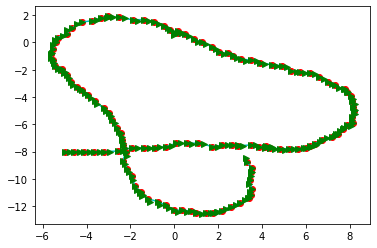

In [6]:
draw(pose[0],pose[1],pose[2])

## Part 2

Now calculate the residual and the Jacobian and update your parameters using LM.

Use LM algorithm. Regarding Jacobian calculation, you can use `jax`'s `jacobian` as part of your main code. However, you still have to separately calculate it analytically and verify if it matches with `jax`'s `jacobian` using frobenius norm `frobNorm()`). Calculation and verification is compulsory, but it is your choice to use whichever as part of your optimization. Use whichever is faster. You can also visualise your Jacobian and see the structure of the matrix (just use `plt.imshow`).

**Regarding LM iterations, stopping criterion, information matrix values.**

1. As your iterations proceed, you have to print relevant information (iteration number and error value: [$F = \frac{1}{2}  \mathbf{f}^{\top} \mathbf{\Omega} \mathbf{f} $ (notes on non-linear LS)](https://saishubodh.notion.site/From-linear-algebra-to-non-linear-weighted-least-squares-optimization-13cf17d318be4d45bb8577c4d3ea4a02#32832dee7d6c4ab49581463d9b784f21) at every step).

2. You have to show the plots (ground truth, noisy & optimized: all 3 in a single plot) at every 10 steps or so.

3. You could start with information values of 500 for odom edges, 700 for loop closure edges, 1000 for anchor edge (same for all dimensions). However, you have to _heavily_ experiment with these values. (Given that you somehow know loop closure information is way more reliable than odometry.). At the end of your experimentation, your error $F = \frac{1}{2}  \mathbf{f}^{\top} \mathbf{\Omega} \mathbf{f} $ should by < 40. Explain your experimentation in detail using tables/plots etc if necessary.
    
Do not worry if you're not getting a perfect trajectory. Our parametrization was oversimplified for the sake of this project. With that being said, it is possible to get the error down to < 40 and make it at least look like an oval shaped trajectory, even if it doesn't perfectly resemble the ground truth. However, using `g2o` (seen later on), you will be getting a close to ground truth trajectory.

**Tip**

Be sure to make your code modular and implement this in various stages. It will help you debug errors. Feel free to create helper functions in other files, just be sure to submit those as well. 

You are free to optimise your code using numba/Jax/torch if you wish, just ensure that you are not using any built in functions for any of the steps. It is only compulsory to verify your Jacobian using Jax.

In [17]:
## Hyperparameters

lm_lambda = 1
iters = 100

## Defining the Anchor
anchor = pose.T[0]

In [12]:
def res_fn(edges,pose,anchor):
    f = jnp.array([])
    
    # Anchor Condition
    f = jnp.append(f,pose.T[0] - anchor)
    f = f.reshape((-1,1))

    # Going using current pose difference and coming back using odometry to get the error
    for i in range(edges[0].shape[0]):
        theta = pose.T[edges[0][i]][-1] # Current Angle
        x = pose.T[edges[0][i]][0] + edges[2][edges[0][i]]*jnp.cos(theta) - edges[3][edges[0][i]]*jnp.sin(theta)
        y = pose.T[edges[0][i]][1] + edges[2][edges[0][i]]*jnp.sin(theta) + edges[3][edges[0][i]]*jnp.cos(theta)
        estimate = jnp.array([ x,y,theta + edges[4][edges[0][i]]]).reshape((-1,1))

        f = jnp.append(f,estimate - pose.T[edges[1][i]].reshape((-1,1)),axis=1)
    return f

def jacobian(pose,edges,anchor):
    jac_fn = jax.jacfwd(res_fn,argnums=0)
    J = jac_fn(pose,edges,anchor)
    return J.reshape((420,-1,1))[:,:,0]

def error_fn(pose,edges,anchor):
    r = res_fn(edges,pose,anchor)
    j = jacobian(pose,edges)

In [13]:
f = error_fn(edges,pose,anchor)
print(f)

AttributeError: 'tuple' object has no attribute 'T'

In [11]:
pose.T[0]

DeviceArray([-5., -8.,  0.], dtype=float32)

## Part 3

- Write about the residuals you computed, its structure and shape. Also explain the structure of the Jacobian and its shape (Express the shape in terms of the number of vertices, loop constraints, and such, not exact numbers). 
- Write about the optimization process and any observations using intermediate plots and such. 

## Part 4

Write the final optimised trajectory as a g2o file. You can do this alongside any of the earlier parts.